# ***Cart Balanced***

## ***SMOTE***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna

pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns

Sizes:
 - Training: 22243
 - Validation: 4767
 - Testing: 4767
Study found. Loading from ../Study/optuna_study_DT_Balanced.pkl...
Model found. Loading from ../Models/decision_tree_model_balanced.pkl...

Validation Metrics:
F1-Score (Validation): 0.8282
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3211
           1       0.65      0.67      0.66       970
           2       0.67      0.71      0.69       586

    accuracy                           0.83      4767
   macro avg       0.74      0.76      0.75      4767
weighted avg       0.83      0.83      0.83      4767



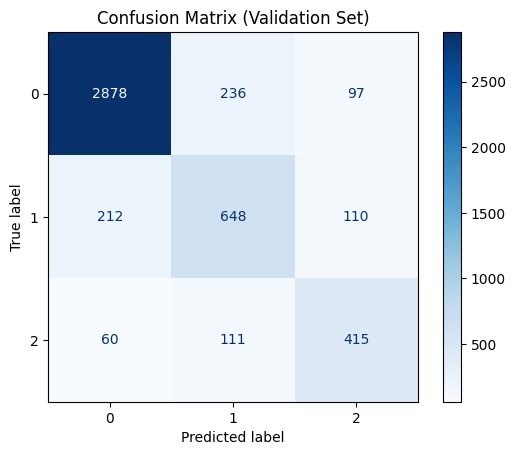

In [16]:
import os
import joblib
import pandas as pd
import optuna
import time
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold

# Cargar datos
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]

# Dividir en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Sizes:\n - Training: {len(X_train)}\n - Validation: {len(X_val)}\n - Testing: {len(X_test)}")

# Definir nombres de archivos
model_filename = "../Models/decision_tree_model_balanced.pkl"
study_filename = "../Study/optuna_study_DT_Balanced.pkl"

# Función objetivo para Optuna con validación cruzada
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.02, log=True)  # Poda posterior
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        # Aplicar SMOTE solo al conjunto de entrenamiento
        smote = SMOTE(random_state=42)
        X_t_resampled, y_t_resampled = smote.fit_resample(X_t, y_t)
        #print("Distribución de clases en X_train después de SMOTE:")
        #print(y_t_resampled.value_counts())

        # Entrenar modelo con los datos balanceados
        model = DecisionTreeClassifier(**param, random_state=42)
        model.fit(X_t_resampled, y_t_resampled)
        
        # Evaluación en el conjunto de validación (sin SMOTE)
        y_v_pred = model.predict(X_v)
        f1_scores.append(f1_score(y_v, y_v_pred, average="weighted"))
    
    return np.mean(f1_scores)

# Cargar o crear estudio de Optuna
if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_dt_balanced = joblib.load(study_filename)
else:
    print("Study not found. Creating a new one...")
    study_dt_balanced = optuna.create_study(direction="maximize")
    start_time = time.time()
    study_dt_balanced.optimize(objective, n_trials=100)
    end_time = time.time()
    joblib.dump(study_dt_balanced, study_filename)
    print(f"Study saved as {study_filename}")
    print(f"Best parameters: {study_dt_balanced.best_params}")
    print(f"Optimization time: {end_time - start_time:.2f} seconds")

# Entrenar modelo final con mejores hiperparámetros
if os.path.exists(model_filename):
    print(f"Model found. Loading from {model_filename}...")
    dt_model_balanced = joblib.load(model_filename)
else:
    print("Model not found. Training a new one...")
    best_params = study_dt_balanced.best_params

    # Aplicar SMOTE al conjunto de entrenamiento completo
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    dt_model_balanced = DecisionTreeClassifier(**best_params, random_state=42)
    dt_model_balanced.fit(X_train_resampled, y_train_resampled)

    joblib.dump(dt_model_balanced, model_filename)
    print(f"Model saved as {model_filename}")

# Evaluación en validación
y_val_pred = dt_model_balanced.predict(X_val)
print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_val, display_labels=dt_model_balanced.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


In [5]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "CART_Balanced", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de CART_Balanced guardado correctamente.


## ***Test Metrics***

In [6]:
# **Métricas de prueba**: Evaluación en el conjunto de prueba
y_test_pred = dt_model_balanced.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("\nFinal Metrics on Test Set:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))



Final Metrics on Test Set:
F1-Score (Test): 0.8284
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      3212
           1       0.64      0.68      0.66       969
           2       0.66      0.70      0.68       586

    accuracy                           0.83      4767
   macro avg       0.74      0.76      0.75      4767
weighted avg       0.83      0.83      0.83      4767



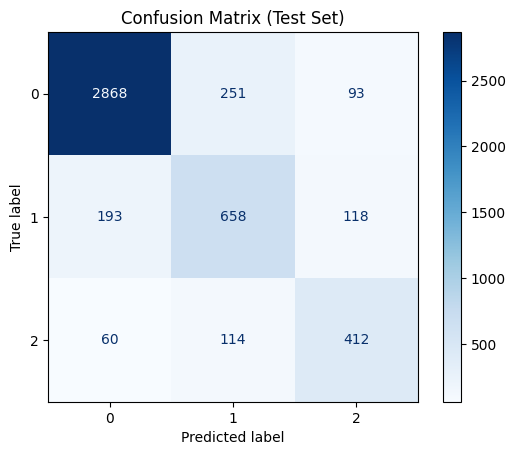

In [7]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Mostrar la matriz de confusión usando ConfusionMatrixDisplay
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=dt_model_balanced.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [8]:
optuna.visualization.plot_optimization_history(study_dt_balanced)

In [9]:
optuna.visualization.plot_parallel_coordinate(study_dt_balanced)

In [10]:
# Extract F1-scores from each trial in the study
f1_scores = [study_dt_balanced.trials[i].value for i in range(len(study_dt_balanced.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_dt_balanced.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [11]:
optuna.visualization.plot_slice(study_dt_balanced, params=['max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion'])

In [12]:
optuna.visualization.plot_param_importances(study_dt_balanced)

## ***Feature Importances***

In [13]:
# Extract feature importances from the trained model
importances = dt_model_balanced.feature_importances_

# Create a DataFrame for easier plotting
feature_names = X_train.columns  # Use the features from the final training set
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and select the top 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importance using Plotly
fig = px.bar(importance_df, 
             x='Feature', 
             y='Importance', 
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',  # Color bars based on importance
             color_continuous_scale='Viridis',  # Use a color scale for better visualization
             text='Importance')  # Display importance values on the bars

# Rotate X-axis labels for better readability
fig.update_layout(xaxis_tickangle=45)

# Show the plot
fig.show()


/home/ssilvera/Escritorio/Proyectos/Modelo_pagos/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



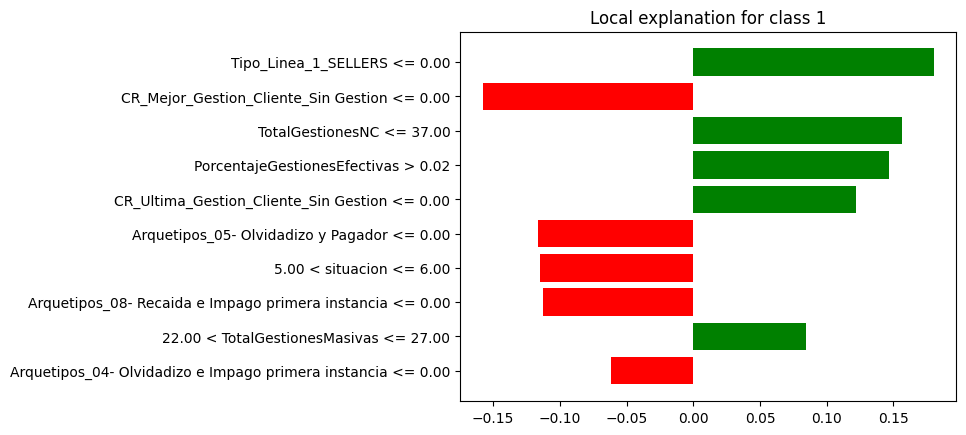

In [14]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,               # Training data (must be a numpy array or pandas dataframe)
    feature_names=X_train.columns,                    # Feature names (column names)
    class_names=y_train.unique(),                     # Target class names (unique classes in target column)
    mode='classification',                             # We're explaining a classification problem
    training_labels=y_train.values                     # Labels for training data
)

# Example 1: Explaining the prediction for the 100th instance in the test set
i = 10
instance = X_test.iloc[i].values.reshape(1, -1)  # Reshape for LIME

exp = explainer.explain_instance(
    data_row=instance[0],                           # Instance to explain
    predict_fn=dt_model_balanced.predict_proba              # Model's predict function (predict_proba for probabilities)
)

# Show explanation in notebook (table of feature importances)
exp.show_in_notebook(show_table=True, show_all=False)

# Generate a plot for the explanation
fig = exp.as_pyplot_figure()
plt.show()

In [15]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_test, y_test_pred, "CART_Balanced", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de CART_Balanced guardado correctamente.


## ***ADASYN***

Sizes:
 - Training: 22243
 - Validation: 4767
 - Testing: 4767
Study found. Loading from ../Study/optuna_study_DT_Balancedd_ADASYN.pkl...
Model found. Loading from ../Models/decision_tree_model_Balanced_ADASYN.pkl...

Validation Metrics:
F1-Score (Validation): 0.8181
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3211
           1       0.62      0.65      0.63       970
           2       0.65      0.74      0.69       586

    accuracy                           0.82      4767
   macro avg       0.73      0.75      0.74      4767
weighted avg       0.82      0.82      0.82      4767



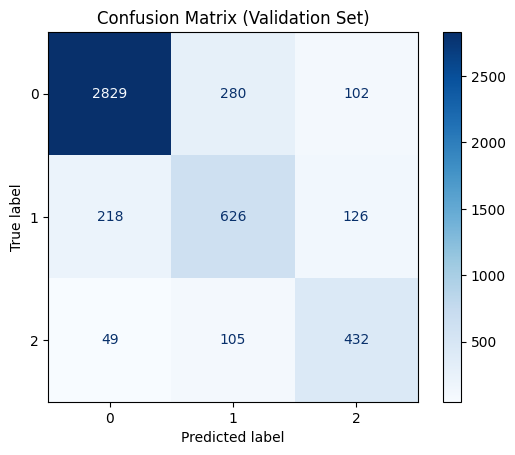

In [31]:
import os
import joblib
import pandas as pd
import optuna
import time
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold

df = pd.read_excel("../Preprocessed data.xlsx")

# Cargar datos
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]

# Dividir en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Sizes:\n - Training: {len(X_train)}\n - Validation: {len(X_val)}\n - Testing: {len(X_test)}")

# Definir nombres de archivos
model_filename = "../Models/decision_tree_model_Balanced_ADASYN.pkl"
study_filename = "../Study/optuna_study_DT_Balancedd_ADASYN.pkl"

# Función objetivo para Optuna con validación cruzada
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 10),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "ccp_alpha": trial.suggest_float("ccp_alpha", 0.0001, 0.02, log=True)  # Poda posterior
    }
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        # Aplicar ADASYN solo al conjunto de entrenamiento
        adasyn = ADASYN(random_state=42)
        X_t_resampled, y_t_resampled = adasyn.fit_resample(X_t, y_t)

        # Imprimir distribución de clases después del balanceo
        #print("\nDistribución de clases en X_train después de ADASYN:")
        #print(y_t_resampled.value_counts())

        # Entrenar modelo con los datos balanceados
        model = DecisionTreeClassifier(**param, random_state=42)
        model.fit(X_t_resampled, y_t_resampled)
        
        # Evaluación en el conjunto de validación (sin ADASYN)
        y_v_pred = model.predict(X_v)
        f1_scores.append(f1_score(y_v, y_v_pred, average="weighted"))
    
    return np.mean(f1_scores)

# Cargar o crear estudio de Optuna
if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_dt_balanced_ad = joblib.load(study_filename)
else:
    print("Study not found. Creating a new one...")
    study_dt_balanced_ad = optuna.create_study(direction="maximize")
    start_time = time.time()
    study_dt_balanced_ad.optimize(objective, n_trials=100)
    end_time = time.time()
    joblib.dump(study_dt_balanced_ad, study_filename)
    print(f"Study saved as {study_filename}")
    print(f"Best parameters: {study_dt_balanced_ad.best_params}")
    print(f"Optimization time: {end_time - start_time:.2f} seconds")

# Entrenar modelo final con mejores hiperparámetros
if os.path.exists(model_filename):
    print(f"Model found. Loading from {model_filename}...")
    dt_model_balanced_ad = joblib.load(model_filename)
else:
    print("Model not found. Training a new one...")
    best_params = study_dt_balanced_ad.best_params

    # Aplicar ADASYN al conjunto de entrenamiento completo
    adasyn = ADASYN(random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

    # Imprimir distribución de clases después del balanceo
    #print("\nDistribución de clases en X_train después de ADASYN:")
    #print(y_train_resampled.value_counts())

    dt_model_balanced_ad = DecisionTreeClassifier(**best_params, random_state=42)
    dt_model_balanced_ad.fit(X_train_resampled, y_train_resampled)

    joblib.dump(dt_model_balanced_ad, model_filename)
    print(f"Model saved as {model_filename}")

# Evaluación en validación
y_val_pred = dt_model_balanced_ad.predict(X_val)
print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_val, display_labels=dt_model_balanced_ad.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


In [20]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "CART_Balanced_ADASYN", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de CART_Balanced_ADASYN guardado correctamente.


## ***Test Metrics***

In [21]:
# **Métricas de prueba**: Evaluación en el conjunto de prueba
y_test_pred = dt_model_balanced_ad.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("\nFinal Metrics on Test Set:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))



Final Metrics on Test Set:
F1-Score (Test): 0.8335
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3212
           1       0.66      0.69      0.67       969
           2       0.64      0.73      0.68       586

    accuracy                           0.83      4767
   macro avg       0.74      0.77      0.76      4767
weighted avg       0.84      0.83      0.83      4767



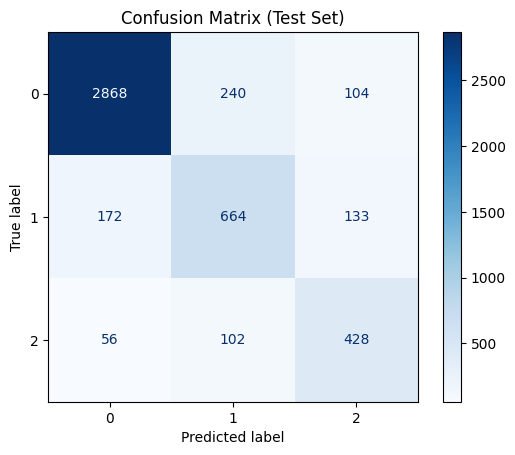

In [22]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Mostrar la matriz de confusión usando ConfusionMatrixDisplay
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=dt_model_balanced_ad.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [23]:
optuna.visualization.plot_optimization_history(study_dt_balanced_ad)

In [24]:
optuna.visualization.plot_parallel_coordinate(study_dt_balanced_ad)

In [25]:
# Extract F1-scores from each trial in the study
f1_scores = [study_dt_balanced_ad.trials[i].value for i in range(len(study_dt_balanced_ad.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_dt_balanced_ad.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [26]:
optuna.visualization.plot_slice(study_dt_balanced_ad, params=['max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion'])

In [27]:
optuna.visualization.plot_param_importances(study_dt_balanced_ad)

## ***Feature Importances***

In [28]:
# Extract feature importances from the trained model
importances = dt_model_balanced_ad.feature_importances_

# Create a DataFrame for easier plotting
feature_names = X_train.columns  # Use the features from the final training set
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance and select the top 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the feature importance using Plotly
fig = px.bar(importance_df, 
             x='Feature', 
             y='Importance', 
             title='Top 20 Feature Importance of the Decision Tree Model',
             labels={'Feature': 'Feature Name', 'Importance': 'Importance Score'},
             color='Importance',  # Color bars based on importance
             color_continuous_scale='Viridis',  # Use a color scale for better visualization
             text='Importance')  # Display importance values on the bars

# Rotate X-axis labels for better readability
fig.update_layout(xaxis_tickangle=45)

# Show the plot
fig.show()


/home/ssilvera/Escritorio/Proyectos/Modelo_pagos/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



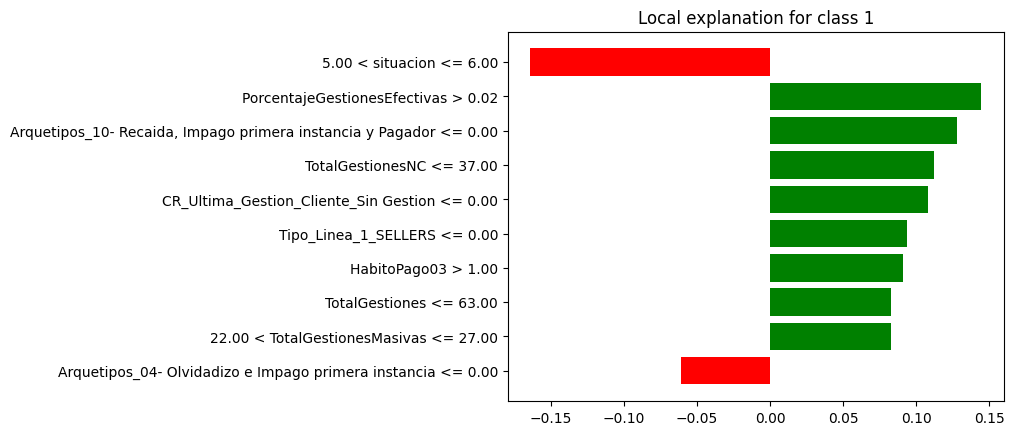

In [29]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,               # Training data (must be a numpy array or pandas dataframe)
    feature_names=X_train.columns,                    # Feature names (column names)
    class_names=y_train.unique(),                     # Target class names (unique classes in target column)
    mode='classification',                             # We're explaining a classification problem
    training_labels=y_train.values                     # Labels for training data
)

# Example 1: Explaining the prediction for the 100th instance in the test set
i = 10
instance = X_test.iloc[i].values.reshape(1, -1)  # Reshape for LIME

exp = explainer.explain_instance(
    data_row=instance[0],                           # Instance to explain
    predict_fn=dt_model_balanced_ad.predict_proba              # Model's predict function (predict_proba for probabilities)
)

# Show explanation in notebook (table of feature importances)
exp.show_in_notebook(show_table=True, show_all=False)

# Generate a plot for the explanation
fig = exp.as_pyplot_figure()
plt.show()

In [30]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_test, y_test_pred, "CART_Balanced_ADASYN", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de CART_Balanced_ADASYN guardado correctamente.
